# Simulations for batch and continuous PAnMBR model

This work mirrors that done for the paper from Puyol 2017. I have decided to rewrite and resimulate the model in Python because I can't be sure that Matlab or Octave will be able to run the code I wrote for versions in 2012 and 2014 and I can't count on having a Matlab license forever.

The simulations are done using odeint which is sufficient for the stiff nature of the set of ODEs.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
%matplotlib inline
plt.style.use('seaborn-whitegrid')
from pam1 import *

## Simulation Case 1

This case is divided into two test cases: i) Analysis of the effects of limiting $\mathrm{NH_4\mbox{-}N}$ and SCOD on each other, and ii) analysis of the effects of limiting $\mathrm{PO_4\mbox{-}P}$ and SCOD on each other.

## Simulation case 2: Analysis of light/dark cycling on PPB metabolism

In [2]:
# Switching irradiance
#########################################################
# USER INPUT
num_steps = 800

days = 2
SS0 = 400.0
SAC0 = 400.0
SIC0 = 7.0E-6
SH20 = 0.0
SIN0 = 100  # 45
SIP0 = 20   # 8.15
SI0 = 150.0
XPB0 = 250.0
XS0 = 100.0
XI0 = 100.0

##########################################################
y0 = [SS0, SAC0, SIC0, SH20, SIN0, SIP0, SI0, XPB0, XS0, XI0,]

time_ode = np.linspace(0,days,num_steps)
#u_t = interp1d(time_input.squeeze(), full_G850.squeeze())

# Store our state outputs here
y_out = [y0]
kMIC = 3.410e-6        # mol HCO3-C/mgCOD/d

# Loop over each point in the dataset

for step in range(num_steps - 1):
    t = [time_ode[step], time_ode[step+1]]
    
    # Get G850 for this step
    if t[0] < 0.5 or (t[0] >= 1.0 and t[0] < 1.5):
        G850 = 10
    else: G850 = 0.0

    # Solve the ODEs
    soln = odeint(pam_batch, y0, t, args=(G850,kMIC))
    y_inter = np.float64(soln[1])
    y_out.append(y_inter)
    y0 = y_inter.tolist()


y_out = np.asarray(y_out)
df_7 = pd.DataFrame(y_out)
df_7['SSout'] =  y_out[:,0]
df_7['SACout'] = y_out[:,1]
df_7['SICout'] = y_out[:,2]
df_7['SH2out'] = y_out[:,3]
df_7['SINout'] = y_out[:,4]
df_7['SIPout'] = y_out[:,5]
df_7['SIout'] = y_out[:,6]
df_7['XPBout'] = y_out[:,7]
df_7['XSout'] = y_out[:,8]
df_7['XIout'] = y_out[:,9] 
df_7['time'] = time_ode

In [3]:
#df_30.to_csv("./results/kmch_low.csv")
#df_7.to_csv("./results/kmch_high.csv")

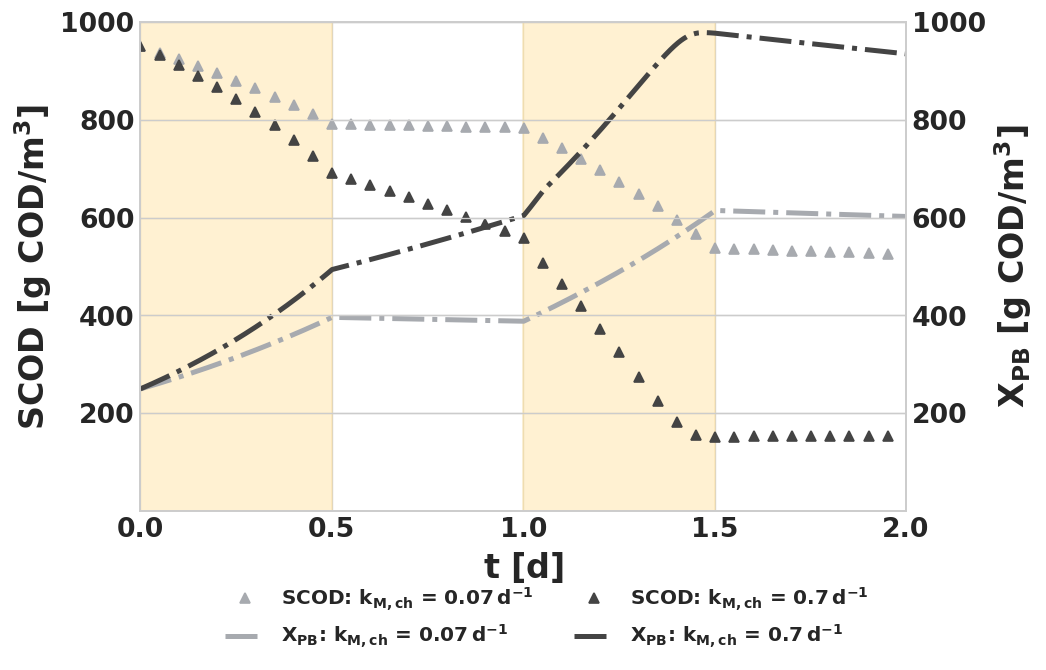

In [4]:
# Plot the graph for batch operation of light/dark cycling over 2 days
from matplotlib.ticker import MaxNLocator

kmch_low = pd.read_csv("./results/kmch_low.csv")
kmch_high = pd.read_csv("./results/kmch_high.csv")

font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 16}

plt.rc('font', **font)

def format_ticks():
    plt.gca().yaxis.set_major_locator(MaxNLocator(prune='lower'))
    plt.locator_params(nbins=5)
    plt.locator_params(numticks=5)
    plt.rc("font", **font)


fig1 = plt.figure(figsize=(9,6), dpi=120)
ax1 = fig1.add_subplot(111)
ax1.tick_params(axis="both",
               reset=False,
               labelsize=16)


SCOD_low = kmch_low['SACout'] + kmch_low['SSout'] + kmch_low['SH2out'] + kmch_low['SIout']
SCOD_high = kmch_high['SACout'] + kmch_high['SSout'] + kmch_high['SH2out'] + kmch_high['SIout']

ax1.plot(kmch_low['time'],
        (SCOD_low),
         "^",
         color="#a7aaaf",
         label='SCOD: $\mathrm{k_{M,ch}}$ = $\mathrm{0.07 \, d^{-1}}$',
         linewidth=3,
         markevery=20)


ax1.plot(kmch_low['time'],
        (kmch_low['XPBout']),
         "-.",
         color="#a7aaaf",
         label='$\mathrm{X_{PB}}$: $\mathrm{k_{M,ch}}$ = $\mathrm{0.07 \, d^{-1}}$',
         linewidth=3,
         markevery=20)


ax1.plot(kmch_high['time'],
        (SCOD_high),
         "^",
         color="#444444",
         label='SCOD: $\mathrm{k_{M,ch}}$ = $\mathrm{0.7 \, d^{-1}}$',
         linewidth=3,
         markevery=20)



ax1.plot(kmch_high['time'],
        (kmch_high['XPBout']),
         "-.",
         color="#444444",
         label='$\mathrm{X_{PB}}$: $\mathrm{k_{M,ch}}$ = $\mathrm{0.7 \, d^{-1}}$',
         linewidth=3,
         markevery=20)



ax1.legend(fontsize=12, loc=(0.1, -0.3), ncol=2)
plt.xlabel(r'$\mathbf{t}$ [d]', fontweight='bold', fontsize=20)
ax1.set_ylabel(r'$\mathbf{SCOD}$ [g COD/m$^3$]', fontweight='bold', fontsize=20)
ax1.axvspan(0, 0.5, alpha=0.5, color='#ffe4a6')
ax1.axvspan(1.0, 1.5, alpha=0.5, color='#ffe4a6')
plt.xlim([0, 2])
plt.ylim([0, 1000])
format_ticks()
ax2 = ax1.twinx()
plt.ylim([0, 1000])
ax2.set_ylabel(r'$\mathbf{X_{PB}}$ [g COD/m$^3$]', fontweight='bold', fontsize=20)
format_ticks()

fig1.tight_layout()

fig1.savefig("./ch2_kmch.pdf")

# Simulation 3: Promotion of $\mathbf{CO_2}$ fixation in DWW from hard water

In [22]:
# Import relevant libraries for MC analysis
from scipy.stats import norm
#########################################################
# USER INPUT
num_steps = 800

# Define the number of MC steps we want
num_mc = 1000

days = 1
SS0 = 0.1
SAC0 = 0.1
SIC0 = 0.05/12
SH20 = 175.0
SIN0 = 45  # 45
SIP0 = 8.15   # 8.15
SI0 = 40.0
XPB0 = 300.0
XS0 = 100.0
XI0 = 100.0

##########################################################
y0 = [SS0, SAC0, SIC0, SH20, SIN0, SIP0, SI0, XPB0, XS0, XI0,]

time_ode = np.linspace(0,days,num_steps)
#u_t = interp1d(time_input.squeeze(), full_G850.squeeze())
y_out = []
# Store our state outputs here
G850 = 20
kMIC_det = 0.041/12000       # mol HCO3-C/mgCOD/d
kMIC_mean = 0.3/12000
kMIC_se = 0.2/np.sqrt(9)/12000

# Generate array for kMIC
np.random.seed(seed=233423)
kMIC_array = norm.rvs(loc=kMIC_mean,
                      scale=kMIC_se,
                      size=(num_mc + 4),
                      random_state=None)

kMIC_array.min()
#kMIC_array[kMIC_array < 0] = 0




# Set the 1st, 2nd and 3rd array elements to be our mean, 95%min and 95%max resp.
kMIC_array[1] = kMIC_mean
kMIC_array[2] = kMIC_array.min()
kMIC_array[3] = kMIC_array.max()

# Set the 0th array element to be our determined value
kMIC_array[0] = kMIC_det

# Solve the ODEs
for i in range(len(kMIC_array)):
    soln = odeint(pam_batch, y0, time_ode, args=(G850,kMIC_array[i]))
    y_out.append(soln[:,2])

len(y_out)



1004

Text(0,0.5,'$\\mathbf{S_{IC} \\, \\,  molC\\, m^{-3}}$')

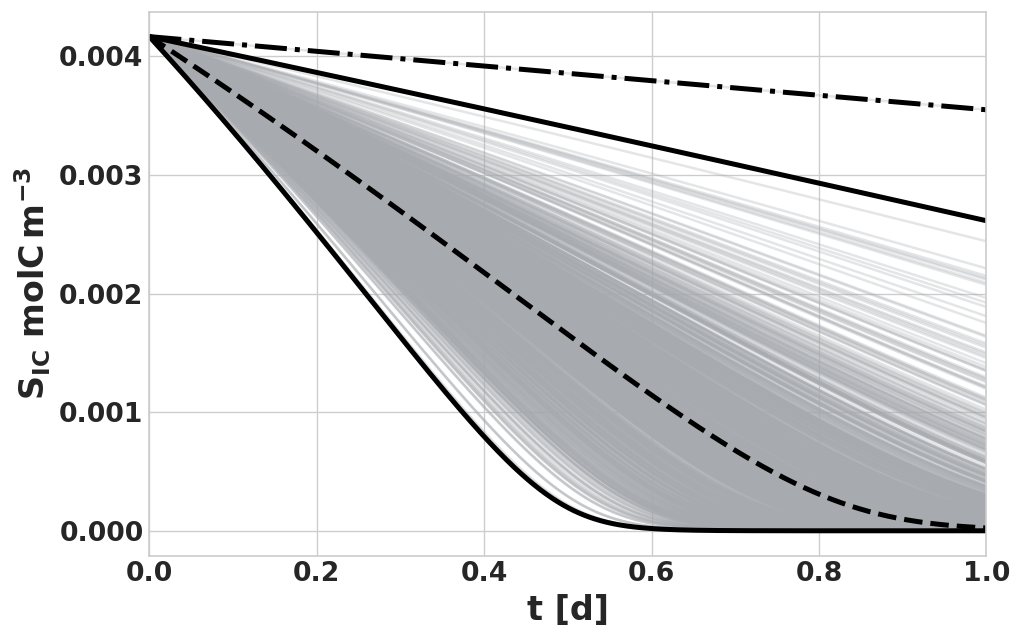

In [26]:
fig2 = plt.figure(figsize=(9,6), dpi=120)
ax = fig2.add_subplot(111)
ax.tick_params(axis="both",
               reset=False,
               labelsize=16,
               which='both',
               direction='out')

font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 16}

plt.rc('font', **font)

for i in range(len(kMIC_array)):
    ax.plot(time_ode, y_out[i],
            color="#a7aaaf",
            alpha=0.3)
    
ax.plot(time_ode, y_out[0],
         '-.',
         color='k',
         linewidth=3,)

ax.plot(time_ode, y_out[1],
         '--',
         color='k',
         linewidth=3,
        markevery=50)

ax.plot(time_ode, y_out[2],
         color='k',
         linewidth=3)

ax.plot(time_ode, y_out[3],
         color='k',
         linewidth=3)

plt.xlim([0, 1])
plt.xlabel("t [d]", fontsize=20, fontweight='bold')
plt.ylabel("$\mathbf{S_{IC} \, \,  molC\, m^{-3}}$", fontsize=20, fontweight='bold')

In [27]:
fig2.savefig("./ch2_auto.pdf")

In [14]:
kMIC_array.min()

3.416666666666667e-06

In [15]:
kMIC_array[2]

1.0678591912068506e-05